### Assignment-2B: Streaming Application

Name: Ashwin Deshmukh<br>
Student Id: 30488745

1. SparkSession is created using a SparkConf object, which would use two local cores
with a proper application name, and use UTC as the timezone
3
(4%)


In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0 pyspark-shell'
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode
from pyspark.sql.functions import split
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, decode, expr
# setting appname, cores and timezone for spark session
conf = SparkConf().setAppName("Stream Analysis").setMaster("local[2]").setAll([('spark.cores.max', '2'),\
                                                                                ("spark.sql.session.timeZone","UTC")])
spark = SparkSession.builder.config(conf = conf).getOrCreate()


2. From the Kafka producers in Task 1.1 and 1.2, ingest the streaming data into Spark
Streaming for both process and memory activities(3%)

In [2]:
# read messages for process producer
topic1 = "Streaming_Linux_process"
df1 = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
    .option("subscribe", topic1) \
    .load()

In [3]:
df1.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [4]:
# read message from memory producer
topic2 = "Streaming_Linux_memory"
df2 = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
    .option("subscribe", topic2) \
    .load()

In [5]:
df2.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



After we have the messages it is necessary to process and flatten this message so as to work on it. We will do the processing next:

Step 1: Convert key and value from kafka message to strin for process and memory events:

In [6]:
df1 = df1.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")  # for process

In [7]:
df2 = df2.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)") # for memory

Step 2: Define the schema for both the events

In [8]:
# define schema for process
schema = ArrayType(StructType([   
    StructField('sequence', StringType(), True), 
    StructField('machine', StringType(), True),
    
           
    StructField("PID", StringType(), True),
    StructField("TRUN", StringType(), True),
    StructField("TSLPI", StringType(), True),
    StructField("TSLPU", StringType(), True),
    StructField("POLI", StringType(), True),
    StructField("NICE", StringType(), True),
    StructField("PRI", StringType(), True),
    StructField("RTPR", StringType(), True),
    StructField("CPUNR", StringType(), True),
    StructField("Status", StringType(), True),
    StructField("EXC", StringType(), True),
    StructField("State", StringType(), True),
    StructField("CPU", StringType(), True),
    StructField("CMD", StringType(), True),
    StructField("ts", StringType(), True)
    
    
]))

In [9]:
# define schema for memory
schema1 = ArrayType(StructType([    
    StructField('sequence', StringType(), True), 
    StructField('machine', StringType(), True),
    
           
    StructField("PID", StringType(), True),
    StructField("MINFLT", StringType(), True),
    StructField("MAJFLT", StringType(), True),
    StructField("VSTEXT", StringType(), True),
    StructField("VSIZE", StringType(), True),
    StructField("RSIZE", StringType(), True),
    StructField("VGROW", StringType(), True),
    StructField("RGROW", StringType(), True),
    StructField("MEM", StringType(), True),
    StructField("CMD", StringType(), True),
    StructField("ts", StringType(), True),
    
    
]))

After declaring the schema we will use from_json to parse the values based on the schema fo both the events

In [10]:
df1=df1.select(F.from_json(F.col("value").cast("string"), schema).alias('parsed_value')) # for process

In [11]:
df2=df2.select(F.from_json(F.col("value").cast("string"), schema1).alias('parsed_value'))  # for memory

Now, the data we have is nested so, we use the explode function to flatten the dataframe.

In [12]:
df1 = df1.select(F.explode(F.col("parsed_value")).alias('unnested_value'))     # flatten process

In [13]:
df2 = df2.select(F.explode(F.col("parsed_value")).alias('unnested_value'))   # flatten memory

We will now rename the columns properly:

In [14]:
# rename process columns
df_pro = df1.select(
                    F.col("unnested_value.sequence").alias("sequence"),
                    F.col("unnested_value.machine").alias("machine"),
                    F.col("unnested_value.PID").alias("PID"),
                    F.col("unnested_value.TRUN").alias("TRUN"),
                    F.col("unnested_value.TSLPI").alias("TSLPI"),
                    F.col("unnested_value.TSLPU").alias("TSLPU"),
                    F.col("unnested_value.POLI").alias("POLI"),
                    F.col("unnested_value.NICE").alias("NICE"),
                    F.col("unnested_value.PRI").alias("PRI"),
    
                    F.col("unnested_value.RTPR").alias("RTPR"),
                    F.col("unnested_value.CPUNR").alias("CPUNR"),
                    F.col("unnested_value.Status").alias("Status"),
                    F.col("unnested_value.EXC").alias("EXC"),
                    F.col("unnested_value.State").alias("State"),
                    F.col("unnested_value.CPU").alias("CPU"),
                    F.col("unnested_value.CMD").alias("CMD"),
                    F.col("unnested_value.ts").alias("ts")
                )

In [15]:
# rename memory columns
df_mem = df2.select(
                    F.col("unnested_value.sequence").alias("sequence"),
                    F.col("unnested_value.machine").alias("machine"),
                    F.col("unnested_value.PID").alias("PID"),
                    F.col("unnested_value.MINFLT").alias("MINFLT"),
                    F.col("unnested_value.MAJFLT").alias("MAJFLT"),
                    F.col("unnested_value.VSTEXT").alias("VSTEXT"),
                    F.col("unnested_value.VSIZE").alias("VSIZE"),
                    F.col("unnested_value.RSIZE").alias("RSIZE"),
                    F.col("unnested_value.VGROW").alias("VGROW"),
    
                    F.col("unnested_value.RGROW").alias("RGROW"),
                    F.col("unnested_value.MEM").alias("MEM"),
                    
                    F.col("unnested_value.CMD").alias("CMD"),
                    F.col("unnested_value.ts").alias("ts")
                )

3. Then the streaming data format should be transformed into the proper formats
following the metadata file schema for both process and memory, similar to
assignment 2A
4
(3%)
    1. The numeric values with extra spaces or “K” / “M” / “G” should be properly
transformed into their correct values


We now have proper dataframes for both the events. We will now transform the columns to correct values. From the previous assignment(A2) we know that the columns MAJFLT,MINFLT,RGROW,VSTEXT,RSIZE of memory event have K,M and G in them.Similary VGROW has extra spaces. So we will fix these columns. 

In [16]:
from pyspark.sql import functions as F
from pyspark.sql.functions import expr
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import isnan, when, count, col
# set the datatype of columns other than the columns mentioned above
df_mem=df_mem.withColumn("sequence",col("sequence").cast(IntegerType()))\
    .withColumn("machine",col("machine").cast(IntegerType()))\
    .withColumn("PID",col("PID").cast(IntegerType()))\
    .withColumn("VSIZE",col("VSIZE").cast(IntegerType()))\
    .withColumn("MEM",col("MEM").cast(DoubleType()))\
    .withColumn("ts",col("ts").cast(IntegerType()))


In [17]:
#convert M in MAJFLT column to a number as it represents million
df_mem=df_mem.withColumn('MAJFLT', F.when(col("MAJFLT").contains('M'),\
                                         expr("substring(MAJFLT,1,length(MAJFLT)-1)")\
                                         .cast('int')*1000000).otherwise(col('MAJFLT')))

In [18]:
#convert K in MAJFLT column to a number as it represents thousand
df_mem=df_mem.withColumn('MAJFLT', F.when(col("MAJFLT").contains('K'),\
                                         expr("substring(MAJFLT,1,length(MAJFLT)-1)")\
                                         .cast('int')*1000).otherwise(col('MAJFLT')))

In [19]:
#convert G in MAJFLT column to a number as it represents 1000000000
#set the datatype of that entry to int for other entries
df_mem=df_mem.withColumn('MAJFLT', F.when(col("MAJFLT").contains('G'),\
                                         expr("substring(MAJFLT,1,length(MAJFLT)-1)")\
                                         .cast('int')*1000000000).otherwise(col('MAJFLT').cast('int')))

In [20]:
#convert K in MINFLT column to a number as it represents thousand

df_mem=df_mem.withColumn('MINFLT', F.when(col("MINFLT").contains('K'),\
                                         expr("substring(MAJFLT,1,length(MAJFLT)-1)")\
                                         .cast('int')*1000).otherwise(col('MINFLT')))

In [21]:
#convert M in MINFLT column to a number as it represents million
df_mem=df_mem.withColumn('MINFLT', F.when(col("MINFLT").contains('M'),\
                                         expr("substring(MAJFLT,1,length(MAJFLT)-1)")\
                                         .cast('int')*1000000).otherwise(col('MINFLT')))

In [22]:
#convert G in MINFLT column to a number as it represents 1000000000
#set the datatype of that entry to int for other entries
df_mem=df_mem.withColumn('MINFLT', F.when(col("MINFLT").contains('G'),\
                                         expr("substring(MAJFLT,1,length(MAJFLT)-1)")\
                                         .cast('int')*1000000000).otherwise(col('MINFLT').cast('int')))

In [23]:
#convert K in RGROW column to a number as it represents thousand

df_mem=df_mem.withColumn('RGROW', F.when(col("RGROW").contains('K'),\
                                         expr("substring(RGROW,1,length(RGROW)-1)")\
                                         .cast('int')*1000).otherwise(col('RGROW')))

In [24]:
#convert M in RGROW column to a number as it represents million
df_mem=df_mem.withColumn('RGROW', F.when(col("RGROW").contains('M'),\
                                         expr("substring(RGROW,1,length(RGROW)-1)")\
                                         .cast('int')*1000000).otherwise(col('RGROW')))

In [25]:
#convert G in RGROW column to a number as it represents 1000000000
#set the datatype of that entry to int for other entries
df_mem=df_mem.withColumn('RGROW', F.when(col("RGROW").contains('G'),\
                                         expr("substring(RGROW,1,length(RGROW)-1)")\
                                         .cast('int')*1000000000).otherwise(col('RGROW').cast('int')))

In [26]:
#convert K in VSTEXT column to a number as it represents thousand

df_mem=df_mem.withColumn('VSTEXT', F.when(col("VSTEXT").contains('K'),\
                                         expr("substring(VSTEXT,1,length(VSTEXT)-1)")\
                                         .cast('int')*1000).otherwise(col('VSTEXT')))

In [27]:
#convert M in VSTEXT column to a number as it represents million
df_mem=df_mem.withColumn('VSTEXT', F.when(col("VSTEXT").contains('M'),\
                                         expr("substring(VSTEXT,1,length(VSTEXT)-1)")\
                                         .cast('int')*1000000).otherwise(col('VSTEXT')))

In [28]:
#convert G in VSTEXT column to a number as it represents 1000000000
#set the datatype of that entry to int for other entries
df_mem=df_mem.withColumn('VSTEXT', F.when(col("VSTEXT").contains('G'),\
                                         expr("substring(VSTEXT,1,length(VSTEXT)-1)")\
                                         .cast('int')*1000000000).otherwise(col('VSTEXT').cast('int')))

In [29]:
#convert M in RSIZE column to a number as it represents million

df_mem=df_mem.withColumn('RSIZE', F.when(col("RSIZE").contains('M'),\
                                         expr("substring(RSIZE,1,length(RSIZE)-1)")\
                                         .cast('int')*1000000).otherwise(col('RSIZE')))

In [30]:
#convert K  in RSIZE column to a number as it represents thousand

df_mem=df_mem.withColumn('RSIZE', F.when(col("RSIZE").contains('K'),\
                                         expr("substring(RSIZE,1,length(RSIZE)-1)")\
                                         .cast('int')*1000).otherwise(col('RSIZE')))

In [31]:
#convert G in RSIZE column to a number as it represents 1000000000
#set the datatype of that entry to int for other entries
df_mem=df_mem.withColumn('RSIZE', F.when(col("RSIZE").contains('G'),\
                                         expr("substring(RSIZE,1,length(RSIZE)-1)")\
                                         .cast('int')*1000000000).otherwise(col('RSIZE').cast('int')))

In [32]:
# remove blank spaces between numbers in the vgrow column
df_mem = df_mem.withColumn('VGROW', regexp_replace('VGROW', ' ', ''))

df_mem = df_mem.withColumn("VGROW",df_mem["VGROW"].cast(IntegerType()))

We will now set the datatype for all columns in the process event:

In [33]:
df_pro=df_pro.withColumn("sequence",col("sequence").cast(IntegerType()))\
    .withColumn("machine",col("machine").cast(IntegerType()))\
    .withColumn("PID",col("PID").cast(IntegerType()))\
    .withColumn("TRUN",col("TRUN").cast(IntegerType()))\
    .withColumn("TSLPI",col("TSLPI").cast(DoubleType()))\
    .withColumn("TSLPU",col("TSLPU").cast(DoubleType()))\
    .withColumn("NICE",col("NICE").cast(IntegerType()))\
    .withColumn("PRI",col("PRI").cast(IntegerType()))\
    .withColumn("RTPR",col("RTPR").cast(IntegerType()))\
    .withColumn("CPUNR",col("CPUNR").cast(DoubleType()))\
    .withColumn("EXC",col("EXC").cast(DoubleType()))\
    .withColumn("CPU",col("CPU").cast(DoubleType()))\
    .withColumn("ts",col("ts").cast(IntegerType()))

    B. The NICE value should also be restored based on the PRI values using their relationship


In [34]:
# when PRI =0 then NICE=0
df_pro=df_pro.withColumn("NICE", F.when(F.col("PRI")==0, 0).otherwise(F.col("NICE")))
# when PRI is other values then NICE =PRI-120
df_pro=df_pro.withColumn("NICE", F.when(F.col("PRI")!=0,(F.col("PRI")-120) ).otherwise(F.col("NICE")))

4. For process and memory, respectively, create a new column “CMD_PID”
concatenating “CMD” and “PID” columns, and a new column “event_time” as
timestamp format based on the unix time in “ts” column (5%)


First we will create the CMD_PID column:

In [35]:
from pyspark.sql.functions import concat
column_list = ['CMD','PID']
df_pro = df_pro.withColumn('CMD_PID',concat(*column_list)) # concat for process event
df_mem = df_mem.withColumn('CMD_PID',concat(*column_list))  # concat for memory event

Let us now create the event_time column

In [36]:
from datetime import datetime
from pyspark.sql.functions import from_utc_timestamp
# adding event_time to process event.
# we cast the ts column as Timestamp then extract year, month,day,hour,min,sec.
# this makes event_time column string
# so we convert it to timestamp again
df_pro=df_pro.withColumn('event_time', F.date_format(df_pro.ts.cast(dataType=TimestampType()), "yyyy-MM-dd HH:mm:ss"))
df_pro=df_pro.withColumn("event_time",col("event_time").cast(TimestampType()))

In [37]:
# adding event_time to memory event.
# we cast the ts column as Timestamp then extract year, month,day,hour,min,sec.
# this makes event_time column string
# so we convert it to timestamp again
df_mem=df_mem.withColumn('event_time', F.date_format(df_mem.ts.cast(dataType=TimestampType()), "yyyy-MM-dd HH:mm:ss"))
df_mem=df_mem.withColumn("event_time",col("event_time").cast(TimestampType()))

    A. Allow 20-second tolerance for possible data delay on “event_time” using watermarking

In [38]:
df_pro=df_pro.withWatermark('event_time','20 seconds')  # creatin a watermark for process

In [39]:
df_mem=df_mem.withWatermark('event_time','20 seconds')   # creatin a watermark for memory

5. Persist the transformed streaming data in parquet format for both process and
memory (5%). The process data should be stored in “process.parquet” in the same folder of
your notebook, and the memory data should be stored in “memory.parquet” in
the same folder of your notebook

Creating a paraquet for process event:

In [40]:
df_pro_para = df_pro.writeStream.format("parquet")\
        .outputMode("append")\
        .option("path","parquet/process.parquet").option("checkpointLocation","parquet/process.parquet/checkpoint").start()

In [41]:
df_pro_para.stop()

Creating a paraquet for memory event:

In [42]:
df_mem_para = df_mem.writeStream.format("parquet")\
        .outputMode("append")\
        .option("path","parquet/memory.parquet").option("checkpointLocation","parquet/memory.parquet/checkpoint").start()

In [43]:
df_mem_para.stop()

6. Load the machine learning models given, and use the models to predict whether each process or memory streaming record is an attack event, respectively (5%)

We will load both models first and then predict:

In [44]:
from pyspark.ml import PipelineModel
# loading both the models
pipelineModel_pro = PipelineModel.load('process_pipeline_model')
pipelineModel_mem = PipelineModel.load('memory_pipeline_model')

In [45]:
# predict for process event
predictions_pro=pipelineModel_pro.transform(df_pro)


In [46]:
# predict for memory event
predictions_mem=pipelineModel_mem.transform(df_mem)

7. Using the prediction result, and monitor the data following the requirements below (30%)<br>
    A. If any program in one machine is predicted as an attack in EITHER process or memory activity prediction, it could be a false alarm or a potential attack. Keep track of the approximate count of such events in every 2-min window for each machine for process and memory, respectively, and write the stream into Spark Memory sink using complete mode


Monitoring the data for process event:

In [47]:
from pyspark.sql.functions import approx_count_distinct
# filter process dataset for attack events then group by window and then get distinct counts
windowCounts_pro = predictions_pro.filter(predictions_pro["prediction"] == 1.0)\
                                 .groupBy(F.window("event_time", "120 seconds"),"machine")\
                                 .agg(approx_count_distinct("CMD_PID").alias("count"))\
                                 .select("window",'machine',"count")


Writing the stream to memory for process event:

In [48]:
# writing the stream in complete mode to the memory
query_pro = windowCounts_pro \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("pred_pro")\
    .trigger(processingTime='5 seconds')\
    .option('truncate','false')\
    .start()

Monitoring the data for memory event:

In [49]:
# filter memory dataset for attack events then group by window and then get distinct counts
windowCounts_mem = predictions_mem.filter(predictions_mem["prediction"] == 1.0)\
                                 .groupBy(F.window("event_time", "120 seconds"),"machine")\
                                 .agg(approx_count_distinct("CMD_PID").alias("count"))\
                                 .select("window",'machine',"count")


Writing the stream to memory for memory event:

In [50]:
# writing the stream in complete mode to the memory
query_mem = windowCounts_pro \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("pred_mem")\
    .trigger(processingTime='5 seconds')\
    .option('truncate','false')\
    .start()

       B. If a program in one machine, having the same “CMD” and “PID” in both process and memory streaming data, is predicted as an attack in BOTH process and memory activity prediction, then this is considered as an attack event. Find the streaming events fulfilling the criteria, create a new column to record the processing time  and persist them in parquet.


To acheive this the followinf steps are followed:

1. Rename columns in process and memory events


In [51]:
# rename columns in process event
predictions_pro1=predictions_pro.select(
                    F.col("sequence").alias("sequence_pro"),
                    F.col("machine").alias("machine_pro"),
                    F.col("PID").alias("PID_pro"),
                    F.col("TRUN").alias("TRUN_pro"),
                    F.col("TSLPI").alias("TSLPI_pro"),
                    F.col("TSLPU").alias("TSLPU_pro"),
                    F.col("POLI").alias("POLI_pro"),
                    F.col("NICE").alias("NICE_pro"),
                    F.col("PRI").alias("PRI_pro"),
                    F.col("RTPR").alias("RTPR_pro"),
                    F.col("CPUNR").alias("CPUNR_pro"),
                    F.col("Status").alias("Status_pro"),
                    F.col("EXC").alias("EXC_pro"),
                    F.col("State").alias("State_pro"),
                    F.col("CPU").alias("CPU_pro"),
                    F.col("CMD").alias("CMD_pro"),
                    F.col("CMD_PID").alias("CMD_PID_pro"),
                    F.col("ts").alias("ts_pro"),
                    F.col("prediction").alias("prediction_pro"))

                   

In [52]:
# rename columns in memory event
predictions_mem1=predictions_mem.select(

                    F.col("sequence").alias("sequence_mem"),
                    F.col("machine").alias("machine_mem"),
                    F.col("PID").alias("PID_mem"),
                    F.col("MINFLT").alias("MINFLT_mem"),
                    F.col("MAJFLT").alias("MAJFLT_mem"),
                    F.col("VSTEXT").alias("VSTEXT_mem"),
                    F.col("VSIZE").alias("VSIZE_mem"),
                    F.col("RSIZE").alias("RSIZE_mem"),
                    F.col("VGROW").alias("VGROW_mem"),
    
                    F.col("RGROW").alias("RGROW_mem"),
                    F.col("MEM").alias("MEM_mem"),
                    
                    F.col("CMD").alias("CMD_mem"),
                    F.col("CMD_PID").alias("CMD_PID_mem"),
                    F.col("ts").alias("ts_mem"),
                    F.col("prediction").alias("prediction_mem")
)

2. join memory and process events on CMD_PID column

In [53]:
joined_df = predictions_pro1.join(predictions_mem1,expr("""CMD_PID_pro == CMD_PID_mem"""),"inner")

3. Filter the joined dataframe for process and memory predictions = 1 

In [54]:
joined_df=joined_df.filter((joined_df["prediction_pro"] == 1.0) & (joined_df["prediction_mem"] == 1.0) )

4. Calculate the value of new column processing_time by subtracting the ts of memory from the ts of process event

In [55]:
joined_df=joined_df.withColumn('processing_time', joined_df.ts_pro - joined_df.ts_mem)

5. Filte the obtained dataframe for all the processing time values less than 30.

In [56]:
final_df=joined_df.filter(joined_df["processing_time"] <30)

6. Save the file in paraquet.

In [57]:
final_para = final_df.writeStream.format("parquet")\
        .outputMode("append")\
        .option("path", "parquet/process_memory_attack.parquet")\
        .option("checkpointLocation", "parquet/process_memory_attack.parquet/checkpoint")\
        .start()

In [58]:
final_para.stop()

8. Visualise the data in line charts for step 7a (5%)

Graph for process event:

In [65]:
def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('stream data visualization') # giving figure a title
        ax.set_xlabel('Time')
        ax.set_ylabel('Count')        
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))

<IPython.core.display.Javascript object>


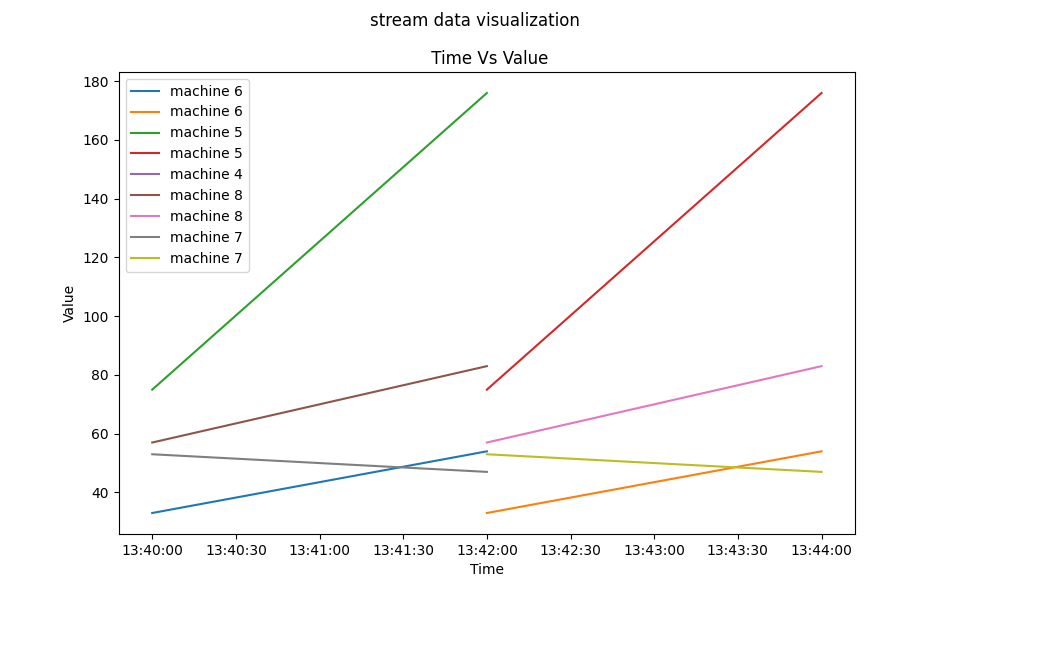

KeyboardInterrupt: 

In [70]:
import time
import matplotlib.pyplot as plt
%matplotlib notebook

fig, ax = init_plots()
window1=[]
window2=[]
window3=[]
window4=[]
window5=[]
cnt1=[]
cnt2=[]
cnt3=[]
cnt4=[]
cnt5=[]
mac=[]
machine_list=[6, 5, 4, 8, 7]
while True:
    # get query result in dataframe
    df = spark.sql("select * from pred_pro").toPandas()
    # loop over dataframe
    for i in range(len(df)):
        a=df.loc[i,'machine']
        # append count and window for each machine to new lists
        if a==machine_list[0]:
            cnt1.append(df.loc[i,'count'])
            window1.append(df.loc[i,'window'])
        if a==machine_list[1]:
            cnt2.append(df.loc[i,'count'])
            window2.append(df.loc[i,'window'])
        if a==machine_list[2]:
            cnt3.append(df.loc[i,'count'])
            window3.append(df.loc[i,'window'])
        if a==machine_list[3]:
            cnt4.append(df.loc[i,'count'])
            window4.append(df.loc[i,'window'])
        if a==machine_list[4]:
            cnt5.append(df.loc[i,'count'])
            window5.append(df.loc[i,'window'])
    
    
    # plot graph
    ax.plot(window1, cnt1,label='machine 6')

    ax.plot(window2, cnt2,label='machine 5')

    ax.plot(window3, cnt3,label='machine 4')

    ax.plot(window4, cnt4,label='machine 8')

    ax.plot(window5, cnt5,label='machine 7')


    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.set_title(' Time Vs Value')
    ax.legend()  # draw legend
    fig.canvas.draw()

    time.sleep(600) # sleep 10 mins


Graph for memory event:

<IPython.core.display.Javascript object>


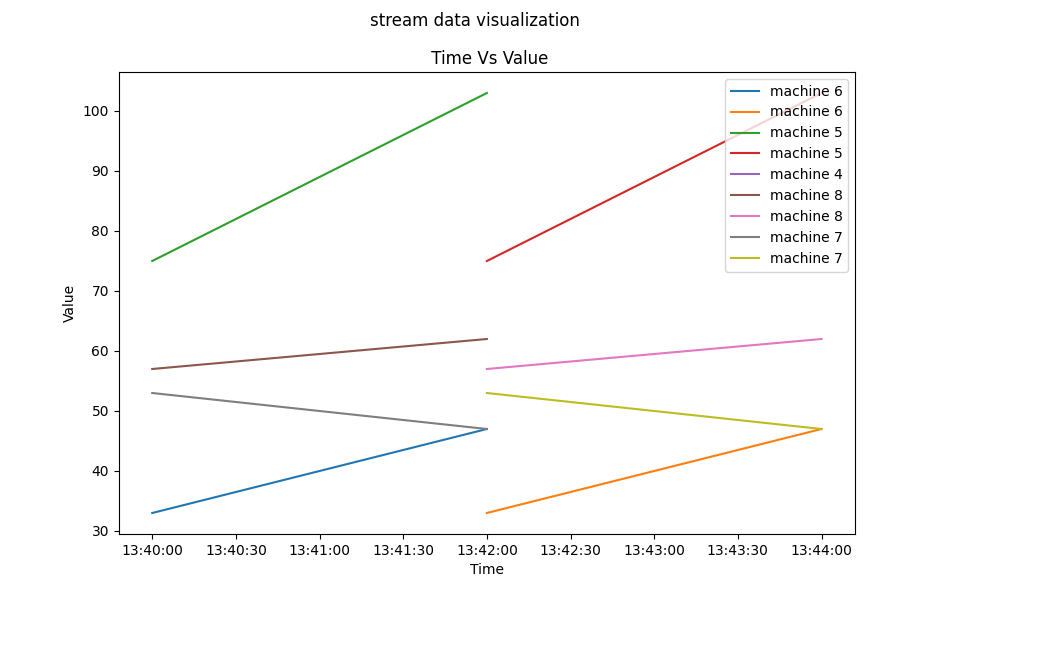

KeyboardInterrupt: 

In [69]:
import time
import matplotlib.pyplot as plt
%matplotlib notebook

fig, ax = init_plots()
window1=[]
window2=[]
window3=[]
window4=[]
window5=[]
cnt1=[]
cnt2=[]
cnt3=[]
cnt4=[]
cnt5=[]
mac=[]
machine_list=[6, 5, 4, 8, 7]
while True:
    # get query result in dataframe
    df = spark.sql("select * from pred_mem").toPandas()
    # loop over dataframe
    for i in range(len(df)):
        a=df.loc[i,'machine']
        # append count and window for each machine to new lists
        if a==machine_list[0]:
            cnt1.append(df.loc[i,'count'])
            window1.append(df.loc[i,'window'])
        if a==machine_list[1]:
            cnt2.append(df.loc[i,'count'])
            window2.append(df.loc[i,'window'])
        if a==machine_list[2]:
            cnt3.append(df.loc[i,'count'])
            window3.append(df.loc[i,'window'])
        if a==machine_list[3]:
            cnt4.append(df.loc[i,'count'])
            window4.append(df.loc[i,'window'])
        if a==machine_list[4]:
            cnt5.append(df.loc[i,'count'])
            window5.append(df.loc[i,'window'])
    
    
    # plot graph
    ax.plot(window1, cnt1,label='machine 6')

    ax.plot(window2, cnt2,label='machine 5')

    ax.plot(window3, cnt3,label='machine 4')

    ax.plot(window4, cnt4,label='machine 8')

    ax.plot(window5, cnt5,label='machine 7')


    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.set_title(' Time Vs Value')
 
    ax.legend()  # draw legend

    


    fig.canvas.draw()

    time.sleep(600) # sleep 10 mins


### References

1. https://lms.monash.edu/mod/resource/view.php?id=7885902
2. https://lms.monash.edu/mod/resource/view.php?id=7851847
3. https://lms.monash.edu/mod/resource/view.php?id=7836926
4. https://lms.monash.edu/mod/resource/view.php?id=7826536
5. https://lms.monash.edu/mod/resource/view.php?id=7826534